<a href="https://colab.research.google.com/github/VVKate/Neural_University_HomeWorks/blob/main/8_%D0%9F%D1%80%D1%8F%D0%BC%D1%8B%D0%B5_%D0%B8_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Июльский курс (2020). Pro. Занятие 8
# Прямые и свёрточные нейронные сети для обработки аудиосигналов
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Вариант1** 
**Задание:**

Использую шаблон ноутбука, напишите загрузку данных и распознавание стилей музыки с помощью Dense сети. Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками

In [ ]:
# Подключаем библиотеки
from google.colab import files 
from tensorflow.keras import utils 
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import time
%matplotlib inline 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
z = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/Базы/genres.zip', 'r') 
z.extractall()

# Задаём названия жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

# Проверяем выгруженные папки и одну из папок
!ls genres 
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Функция параметризации аудио
def get_features(y, sr):
  # Частота цветности
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

  # Среднеквадратичная амплитуда
  rmse = np.mean(librosa.feature.rmse(y=y)) 

  # Спектральный центроид
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) 

  # Ширина полосы частот
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

  # Спектральный спад частоты
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

  # Пересечения нуля
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))

  # Мел кепстральные коэффициенты
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  # Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  # По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))
  
  # Возвращаем получившийся список
  return out

In [ ]:
# Формируем обучающую выборку
X_train = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] # Берём текущий жанр
  # Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    # Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    # Загружаем в y аудиосигнал 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    # Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    # Добавляем строку в X_train
    X_train.append(out)
    # Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  # Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

# Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 95c
Жанр classical готов -> 92c
Жанр country готов -> 91c
Жанр disco готов -> 91c
Жанр hiphop готов -> 91c
Жанр jazz готов -> 92c
Жанр metal готов -> 93c
Жанр pop готов -> 93c
Жанр reggae готов -> 93c
Жанр rock готов -> 92c


In [ ]:
#Создаём backup
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
# Нормируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Разделяем выборку на обучающую и проверочную
# Для проверочной выборки используем 10% примеров
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


Epoch 1/400
45/45 [==============================] - 0s 5ms/step - loss: 2.1824 - accuracy: 0.2089 - val_loss: 1.7722 - val_accuracy: 0.3500
Epoch 2/400
45/45 [==============================] - 0s 4ms/step - loss: 1.8796 - accuracy: 0.3178 - val_loss: 1.6299 - val_accuracy: 0.4200
Epoch 3/400
45/45 [==============================] - 0s 3ms/step - loss: 1.7076 - accuracy: 0.3667 - val_loss: 1.5484 - val_accuracy: 0.4500
Epoch 4/400
45/45 [==============================] - 0s 3ms/step - loss: 1.6248 - accuracy: 0.4133 - val_loss: 1.4866 - val_accuracy: 0.4900
Epoch 5/400
45/45 [==============================] - 0s 3ms/step - loss: 1.5676 - accuracy: 0.4356 - val_loss: 1.4533 - val_accuracy: 0.5400
Epoch 6/400
45/45 [==============================] - 0s 3ms/step - loss: 1.5078 - accuracy: 0.4600 - val_loss: 1.4152 - val_accuracy: 0.5500
Epoch 7/400
45/45 [==============================] - 0s 3ms/step - loss: 1.4911 - accuracy: 0.4522 - val_loss: 1.3856 - val_accuracy: 0.5700
Epoch 8/400
4

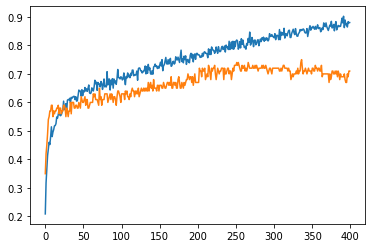

In [ ]:
indexes = range(0,26)

#Создаём модель 
model = Sequential()

model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dropout(0.4))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=400,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

# Визуализируем результаты
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
last_val_accuracy = history.history['val_accuracy'][-1]
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy*100, 2), "%")

Точность классификации данных на проверочной выборке: 71.0 %


Тестируем сеть

In [ ]:
# Возьмеи по одной песне из каждого жанра и протестируем работу сети

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for i in genres:
    songname = './genres/' + i + '/' + i + '.00000.au'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    out = np.array(out).reshape(1,26)
    out = scaler.transform(out)

    #Делаем predict
    y = model.predict(out)

    pred = np.argmax(y)
    real = genres.index(i)

    if pred == real: print("Жанр {} распознан верно!!!".format(i))
    else: print("Жанр {} - ошибочка вышла, попробуйте еще раз!".format(i))

Жанр blues - ошибочка вышла, попробуйте еще раз!
Жанр classical распознан верно!!!
Жанр country распознан верно!!!
Жанр disco распознан верно!!!
Жанр hiphop распознан верно!!!
Жанр jazz - ошибочка вышла, попробуйте еще раз!
Жанр metal распознан верно!!!
Жанр pop распознан верно!!!
Жанр reggae распознан верно!!!
Жанр rock распознан верно!!!


Забавный результат получился, слушаю радио, в наушниках диктор: "...dолна спокойствия и комфорта. Джаз, блюз ..." И как раз в этот момент Нейронка выдает результат что именно их то распазнать не может)))

А вообще говоря результат неполучился не такой плохой, учитывая что следуя шаблону ноутбука данного для этого задания мы используем не все 37 параметров звука, а только 26, то **точность классификации данных на проверочной выборке: 71.0 %** вполне можно считать хорошим результатом!

## **PRO** 


### **Вариант 1**
**Задание:**

Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную


In [ ]:
# Подключаем библиотеки
from google.colab import files 
from tensorflow.keras import utils 
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import time
%matplotlib inline 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPool1D, SpatialDropout1D, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import plot_model

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
z = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/Базы/genres.zip', 'r') 
z.extractall()

# Задаём названия жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

# Проверяем выгруженные папки и одну из папок
!ls genres 
!ls genres/rock

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
rock.00000.au  rock.00020.au  rock.00040.au  rock.00060.au  rock.00080.au
rock.00001.au  rock.00021.au  rock.00041.au  rock.00061.au  rock.00081.au
rock.00002.au  rock.00022.au  rock.00042.au  rock.00062.au  rock.00082.au
rock.00003.au  rock.00023.au  rock.00043.au  rock.00063.au  rock.00083.au
rock.00004.au  rock.00024.au  rock.00044.au  rock.00064.au  rock.00084.au
rock.00005.au  rock.00025.au  rock.00045.au  rock.00065.au  rock.00085.au
rock.00006.au  rock.00026.au  rock.00046.au  rock.00066.au  rock.00086.au
rock.00007.au  rock.00027.au  rock.00047.au  rock.00067.au  rock.00087.au
rock.00008.au  rock.00028.au  rock.00048.au  rock.00068.au  rock.00088.au
rock.00009.au  rock.00029.au  rock.00049.au  rock.00069.au  rock.00089.au
rock.00010.au  rock.00030.au  rock.00050.au  rock.00070.au  rock.00090.au
rock.00011.au  rock.00031.au  rock.00051.au  rock.00071.au  rock.00091.au
rock.00012.au  rock.00032.au  rock.00052

In [ ]:
def get_features(y, sr):
  # Двумерные
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) # Частота цветности
  mfcc = librosa.feature.mfcc(y=y, sr=sr)               # Мел кепстральные коэффициенты

  # Одномерные
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) # Спектральный центроид
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Ширина полосы частот
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)    # Спектральный спад частоты
  zcr = librosa.feature.zero_crossing_rate(y)               # Пересечения нуля

  # Возвращаем получившийся список
  return chroma_stft, mfcc, spec_cent, spec_bw, rolloff, zcr

In [ ]:
# Формируем обучающую выборку
X_train_1 = []
X_train_2 = []
X_train_3 = []
X_train_4 = []
X_train_5 = []
X_train_6 = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] # Берём текущий жанр
  # Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    # Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    # Загружаем в y аудиосигнал 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    # Превращаем сигнал в параметризованные данные
    for p in range(0, (int(len(y)//22050))-4):
      chroma_stft, mfcc, spec_cent, spec_bw, rolloff, zcr = get_features(y[p*sr:(p+4)*sr], sr)

      # Добавляем строку в X_train
      X_train_1.append(chroma_stft)
      X_train_2.append(mfcc)
      X_train_3.append(spec_cent)
      X_train_4.append(spec_bw)
      X_train_5.append(rolloff)
      X_train_6.append(zcr)

      # Добавляем в Y_train номер классов в формате ohe
      Y_train.append(utils.to_categorical(i, len(genres)))
  

  # Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()


Жанр blues готов -> 285c
Жанр classical готов -> 278c
Жанр country готов -> 283c
Жанр disco готов -> 293c
Жанр hiphop готов -> 297c
Жанр jazz готов -> 295c
Жанр metal готов -> 300c
Жанр pop готов -> 306c
Жанр reggae готов -> 309c
Жанр rock готов -> 313c


In [ ]:
# Превращаем обучающую выборку в numpy массивы
X_train_1 = np.array([X_train_1])
X_train_2 = np.array([X_train_2])
X_train_3 = np.array([X_train_3])
X_train_4 = np.array([X_train_4])
X_train_5 = np.array([X_train_5])
X_train_6 = np.array([X_train_6])
Y_train = np.array([Y_train])

In [ ]:
# Проверяем размерность xTrain
print(Y_train.shape)
y_train_class = np.argmax(Y_train[0], axis=1)
print(len(y_train_class))

(1, 25991, 10)
25991


In [ ]:
np.save('drive/My Drive/X_train_1',X_train_1)
np.save('drive/My Drive/X_train_2',X_train_2)
np.save('drive/My Drive/X_train_3',X_train_3)
np.save('drive/My Drive/X_train_4',X_train_4)
np.save('drive/My Drive/X_train_5',X_train_5)
np.save('drive/My Drive/X_train_6',X_train_6)
np.save('drive/My Drive/Y_train',Y_train)
np.save('drive/My Drive/y_train_class',y_train_class)

In [ ]:
# X_train_1 = np.load('drive/My Drive/X_train_1.npy')
# X_train_2 = np.load('drive/My Drive/X_train_2.npy')
# X_train_3 = np.load('drive/My Drive/X_train_3.npy')
# X_train_4 = np.load('drive/My Drive/X_train_4.npy')
# X_train_5 = np.load('drive/My Drive/X_train_5.npy')
# X_train_6 = np.load('drive/My Drive/X_train_6.npy')
# Y_train = np.load('drive/My Drive/Y_train.npy')
# y_train_class = np.load('drive/My Drive/y_train_class.npy')

In [ ]:
# Выводим размеры обучающей выборки
print(X_train_1.shape)
print(X_train_2.shape)
print(X_train_3.shape)
print(X_train_4.shape)
print(X_train_5.shape)
print(X_train_6.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1, 25991, 12, 173)
(1, 25991, 20, 173)
(1, 25991, 1, 173)
(1, 25991, 1, 173)
(1, 25991, 1, 173)
(1, 25991, 1, 173)
(1, 25991, 10)
(25991,)


In [ ]:
# Убираем лишнюю размерность
X_train_1 = X_train_1.reshape(-1, 12, 173)
X_train_2 = X_train_2.reshape(-1, 20, 173)
X_train_3 = X_train_3.reshape(-1, 1, 173)
X_train_4 = X_train_4.reshape(-1, 1, 173)
X_train_5 = X_train_5.reshape(-1, 1, 173)
X_train_6 = X_train_6.reshape(-1, 1, 173)
Y_train = Y_train.reshape(-1, 10)
y_train_class = y_train_class.reshape(-1,)
# Выводим размеры обучающей выборки
print(X_train_1.shape)
print(X_train_2.shape)
print(X_train_3.shape)
print(X_train_4.shape)
print(X_train_5.shape)
print(X_train_6.shape)
print(Y_train.shape)
print(y_train_class.shape)

(25991, 12, 173)
(25991, 20, 173)
(25991, 1, 173)
(25991, 1, 173)
(25991, 1, 173)
(25991, 1, 173)
(25991, 10)
(25991,)


In [ ]:
y_train_class

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
input1 = Input((12,173))
x1 = Conv1D(32, 3, padding='same', activation='relu', strides=2)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = Conv1D(64, 3, padding='same', activation='relu', strides=2)(x1)
x1 = GlobalMaxPool1D()(x1)
x1 = Dropout(0.3)(x1)

input2 = Input((20,173))
x2 = Conv1D(32, 3, padding='same', activation='relu', strides=2)(input2)
x2 = SpatialDropout1D(0.3)(x2)
x2 = Conv1D(64, 3, padding='same', activation='relu', strides=2)(x2)
x2 = GlobalMaxPool1D()(x2)
x2 = Dropout(0.3)(x2)

input3 = Input((4,))
x3 = Dense(64, activation='relu')(input3)
x3 = Dropout(0.3)(x3)

x = concatenate([x1,x2,x3])

x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output = Dense(10, activation='softmax')(x)

In [ ]:
model = Model([input1, input2, input3], output)

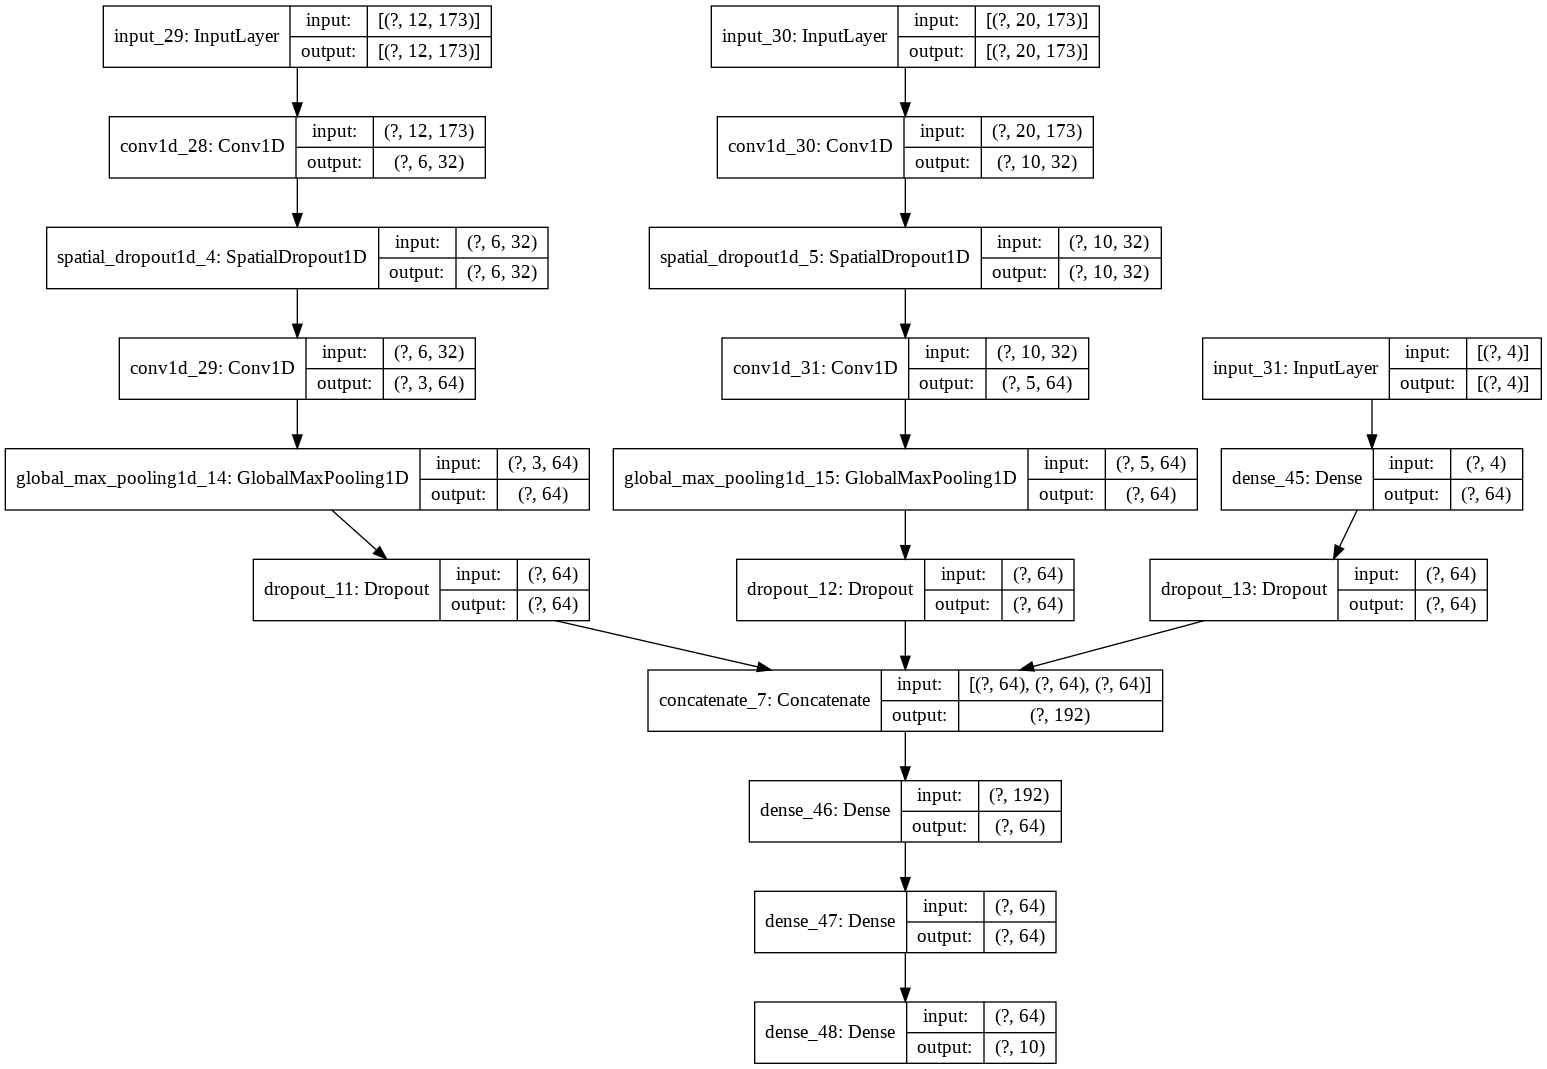

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
X3 = np.concatenate([X_train_3, X_train_4, X_train_5, X_train_6], axis=1)
X3.shape

(25991, 4, 173)

In [ ]:
X3 = X3.mean(axis=-1)
X3.shape

(25991, 4)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit([X_train_1, X_train_2, X3], Y_train, epochs=20, validation_split=0.2, batch_size=64, shuffle=True)

Epoch 1/20
325/325 [==============================] - 2s 6ms/step - loss: 51.5953 - accuracy: 0.2328 - val_loss: 224.0315 - val_accuracy: 0.0000e+00
Epoch 2/20
325/325 [==============================] - 2s 6ms/step - loss: 3.7331 - accuracy: 0.2738 - val_loss: 238.6432 - val_accuracy: 0.0000e+00
Epoch 3/20
325/325 [==============================] - 2s 5ms/step - loss: 2.0467 - accuracy: 0.3280 - val_loss: 234.4014 - val_accuracy: 0.0000e+00
Epoch 4/20
325/325 [==============================] - 2s 5ms/step - loss: 1.7939 - accuracy: 0.3593 - val_loss: 196.2229 - val_accuracy: 0.0000e+00
Epoch 5/20
325/325 [==============================] - 2s 5ms/step - loss: 1.6353 - accuracy: 0.3903 - val_loss: 172.3898 - val_accuracy: 0.0000e+00
Epoch 6/20
325/325 [==============================] - 2s 5ms/step - loss: 1.5197 - accuracy: 0.4172 - val_loss: 150.2488 - val_accuracy: 0.0000e+00
Epoch 7/20
325/325 [==============================] - 2s 5ms/step - loss: 1.4774 - accuracy: 0.4336 - val_loss:

In [ ]:
X_train_2.shape

(25991, 20, 173)

In [ ]:
input = Input((20,173))
x = Dense(64, activation='relu')(input)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

In [ ]:
simple_model = Model(input, output)
simple_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
simple_model.fit(X_train_2, Y_train, epochs=20, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/20
325/325 [==============================] - 1s 4ms/step - loss: 1.2479 - accuracy: 0.5257 - val_loss: 10.7773 - val_accuracy: 0.0000e+00
Epoch 2/20
325/325 [==============================] - 1s 4ms/step - loss: 1.0002 - accuracy: 0.6239 - val_loss: 10.9709 - val_accuracy: 0.0000e+00
Epoch 3/20
325/325 [==============================] - 1s 4ms/step - loss: 0.9025 - accuracy: 0.6652 - val_loss: 11.7233 - val_accuracy: 0.0000e+00
Epoch 4/20
325/325 [==============================] - 1s 4ms/step - loss: 0.8429 - accuracy: 0.6877 - val_loss: 11.6403 - val_accuracy: 0.0000e+00
Epoch 5/20
325/325 [==============================] - 1s 4ms/step - loss: 0.7931 - accuracy: 0.7072 - val_loss: 11.8694 - val_accuracy: 0.0000e+00
Epoch 6/20
325/325 [==============================] - 1s 4ms/step - loss: 0.7432 - accuracy: 0.7262 - val_loss: 12.9097 - val_accuracy: 0.0000e+00
Epoch 7/20
325/325 [==============================] - 1s 4ms/step - loss: 0.7107 - accuracy: 0.7342 - val_loss: 13.355

**Так как результаты совсем удручающие, попробуем применить балансировку**

**1) downsampling**

In [ ]:
count[0].min()

2597.0

In [ ]:
indices = []
for i in range(10):
  indices.extend(np.arange(y_train_class.size)[y_train_class==i][:38])

In [ ]:
len(indices)

380

In [ ]:
simple_model.fit(X_train_2[indices], Y_train[indices], epochs=20, batch_size=64, shuffle=True, validation_split=0.2)

Epoch 1/20
5/5 [==============================] - 0s 10ms/step - loss: 0.4236 - accuracy: 0.8257 - val_loss: 17.3453 - val_accuracy: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.2560 - accuracy: 0.9309 - val_loss: 17.7986 - val_accuracy: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - loss: 0.1704 - accuracy: 0.9539 - val_loss: 18.1139 - val_accuracy: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 0.1178 - accuracy: 0.9803 - val_loss: 18.1481 - val_accuracy: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.1208 - accuracy: 0.9605 - val_loss: 18.3817 - val_accuracy: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0833 - accuracy: 0.9836 - val_loss: 18.6257 - val_accuracy: 0.0000e+00
Epoch 7/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0883 - accuracy: 0.9704 - val_loss: 18.7785 - val_accuracy: 0.0000e+0

**2) upsampling**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train_2, Y_train, test_size=0.2)

In [ ]:
y_train_cls = y_train.argmax(-1)
y_train_cls.shape

(20792,)

In [ ]:
max = count[0].max()
max

2600.0

In [ ]:
coefs = (count[0].max()/count[0]).astype(int)
train_indices = []
for i in range(10):
  train_indices.extend(list(np.arange(y_train_cls.size)[y_train_cls==i])*coefs[i])

In [ ]:
y_train[train_indices].shape

(20792, 10)

In [ ]:
history = simple_model.fit(x_train[train_indices], y_train[train_indices], epochs=50, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/50
325/325 [==============================] - 1s 4ms/step - loss: 0.9776 - accuracy: 0.6726 - val_loss: 0.5835 - val_accuracy: 0.8077
Epoch 2/50
325/325 [==============================] - 1s 4ms/step - loss: 0.7582 - accuracy: 0.7264 - val_loss: 0.5491 - val_accuracy: 0.8192
Epoch 3/50
325/325 [==============================] - 1s 4ms/step - loss: 0.7166 - accuracy: 0.7419 - val_loss: 0.5375 - val_accuracy: 0.8255
Epoch 4/50
325/325 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.7523 - val_loss: 0.5093 - val_accuracy: 0.8329
Epoch 5/50
325/325 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.7635 - val_loss: 0.5007 - val_accuracy: 0.8359
Epoch 6/50
325/325 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.7635 - val_loss: 0.4673 - val_accuracy: 0.8469
Epoch 7/50
325/325 [==============================] - 1s 4ms/step - loss: 0.6246 - accuracy: 0.7739 - val_loss: 0.4673 - val_accuracy: 0.8432
Epoch 

In [ ]:
last_val_accuracy = history.history['val_accuracy'][-1]
print("Точность классификации данных на проверочной выборке, на последней эпохе обучения:", round(last_val_accuracy*100, 2), "%")

Точность классификации данных на проверочной выборке, на последней эпохе обучения: 91.04 %


In [ ]:
list = []
for n in range(10):
  val_accuracy = history.history['val_accuracy'][-10 + n]
  list.append(str(round(val_accuracy*100, 2)) + "%")
print("Точность классификации данных на проверочной выборке, на последних 10 эпохах обучения:\n", list)

Точность классификации данных на проверочной выборке, на последних 10 эпохах обучения:
 ['91.17%', '91.31%', '91.46%', '91.38%', '91.79%', '91.71%', '91.17%', '91.46%', '90.88%', '91.04%']


**Данный результат полностью удовлетворяет условие задачи (Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения). Из чего можно сделать вывод, что выбранный подход по подготовке данных и самой нейронной сети очень хорошо подходит для решения подобных задач.** 

## **Ultra PRO** 


### **Вариант 1**

**Задание:**

Найдите на Kaggle любую базу с аудио и напишите распознавание аудио:
1. Спарсите, разделите и нормализуйте данные
2. Разделите данные на обучающую и проверочную выборки
3. Сделайте классификацию 
4. Напишите ваши результаты и выводы

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков

from tensorflow.keras.optimizers import Adam, RMSprop #Подключаем оптимизаторы
from tensorflow.keras.models import Sequential, Model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

from tensorflow.keras.utils import plot_model

Для данного задания была найдена и скачена с сайта Kaggle база голосов 10 разных спикеров. Язык  - английский. 8 мужчин и 2 женщины. 

In [ ]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/10_speakers_audio_data.zip' #распаковываем архив на google диске на локальный диск google colaboratory 

speakers = os.listdir('10_speakers_audio_data') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls 10_speakers_audio_data 

Speaker_0001  Speaker_0003  Speaker_0005  Speaker_0007	Speaker_0009
Speaker_0002  Speaker_0004  Speaker_0006  Speaker_0008	Speaker_0010


In [ ]:
#И одну из папок
!ls 10_speakers_audio_data/Speaker_0001

Speaker_0001_00000.wav	Speaker_0001_00017.wav	Speaker_0001_00034.wav
Speaker_0001_00001.wav	Speaker_0001_00018.wav	Speaker_0001_00035.wav
Speaker_0001_00002.wav	Speaker_0001_00019.wav	Speaker_0001_00036.wav
Speaker_0001_00003.wav	Speaker_0001_00020.wav	Speaker_0001_00037.wav
Speaker_0001_00004.wav	Speaker_0001_00021.wav	Speaker_0001_00038.wav
Speaker_0001_00005.wav	Speaker_0001_00022.wav	Speaker_0001_00039.wav
Speaker_0001_00006.wav	Speaker_0001_00023.wav	Speaker_0001_00040.wav
Speaker_0001_00007.wav	Speaker_0001_00024.wav	Speaker_0001_00041.wav
Speaker_0001_00008.wav	Speaker_0001_00025.wav	Speaker_0001_00042.wav
Speaker_0001_00009.wav	Speaker_0001_00026.wav	Speaker_0001_00043.wav
Speaker_0001_00010.wav	Speaker_0001_00027.wav	Speaker_0001_00044.wav
Speaker_0001_00011.wav	Speaker_0001_00028.wav	Speaker_0001_00045.wav
Speaker_0001_00012.wav	Speaker_0001_00029.wav	Speaker_0001_00046.wav
Speaker_0001_00013.wav	Speaker_0001_00030.wav	Speaker_0001_00047.wav
Speaker_0001_00014.wav	Speaker_000

In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(speakers)):
  g = speakers[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./10_speakers_audio_data/{g}'):
    #Получаем имя песни
    songname = f'./10_speakers_audio_data/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(speakers)))

  #Выводим информацию о готовности обработки базы
  print("Спикер ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Спикер Speaker_0006 готов -> 60c
Спикер Speaker_0005 готов -> 58c
Спикер Speaker_0003 готов -> 58c
Спикер Speaker_0007 готов -> 58c
Спикер Speaker_0001 готов -> 58c
Спикер Speaker_0002 готов -> 58c
Спикер Speaker_0008 готов -> 57c
Спикер Speaker_0009 готов -> 58c
Спикер Speaker_0010 готов -> 58c
Спикер Speaker_0004 готов -> 58c


In [ ]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
X_train = []
Y_train = []
X_train = X_train_backup 
Y_train = Y_train_backup

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 

In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(500, 37)
(500, 10)
(500,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-0.92534621 -0.46436784 -0.67116998 -0.52910736 -0.28006652 -1.03889956
 -1.05763029  0.90785306 -0.31727363  0.63059118  0.73672388  0.32202493
  0.36096599 -0.39604965 -0.07747834 -0.29633089 -0.94842058 -0.96535073
 -0.29623486 -0.15953112 -0.42691583 -0.79831225  0.26910343 -0.39407113
 -0.5940868  -1.55617679 -1.95587422 -1.64333001 -0.94584988  0.19488897
  0.07419262 -0.32692576 -0.42409733 -0.15194597  0.24065653 -0.28684766
 -1.0963149 ]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1, shuffle=True)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(450, 37)
(450,)
(50, 37)
(50,)


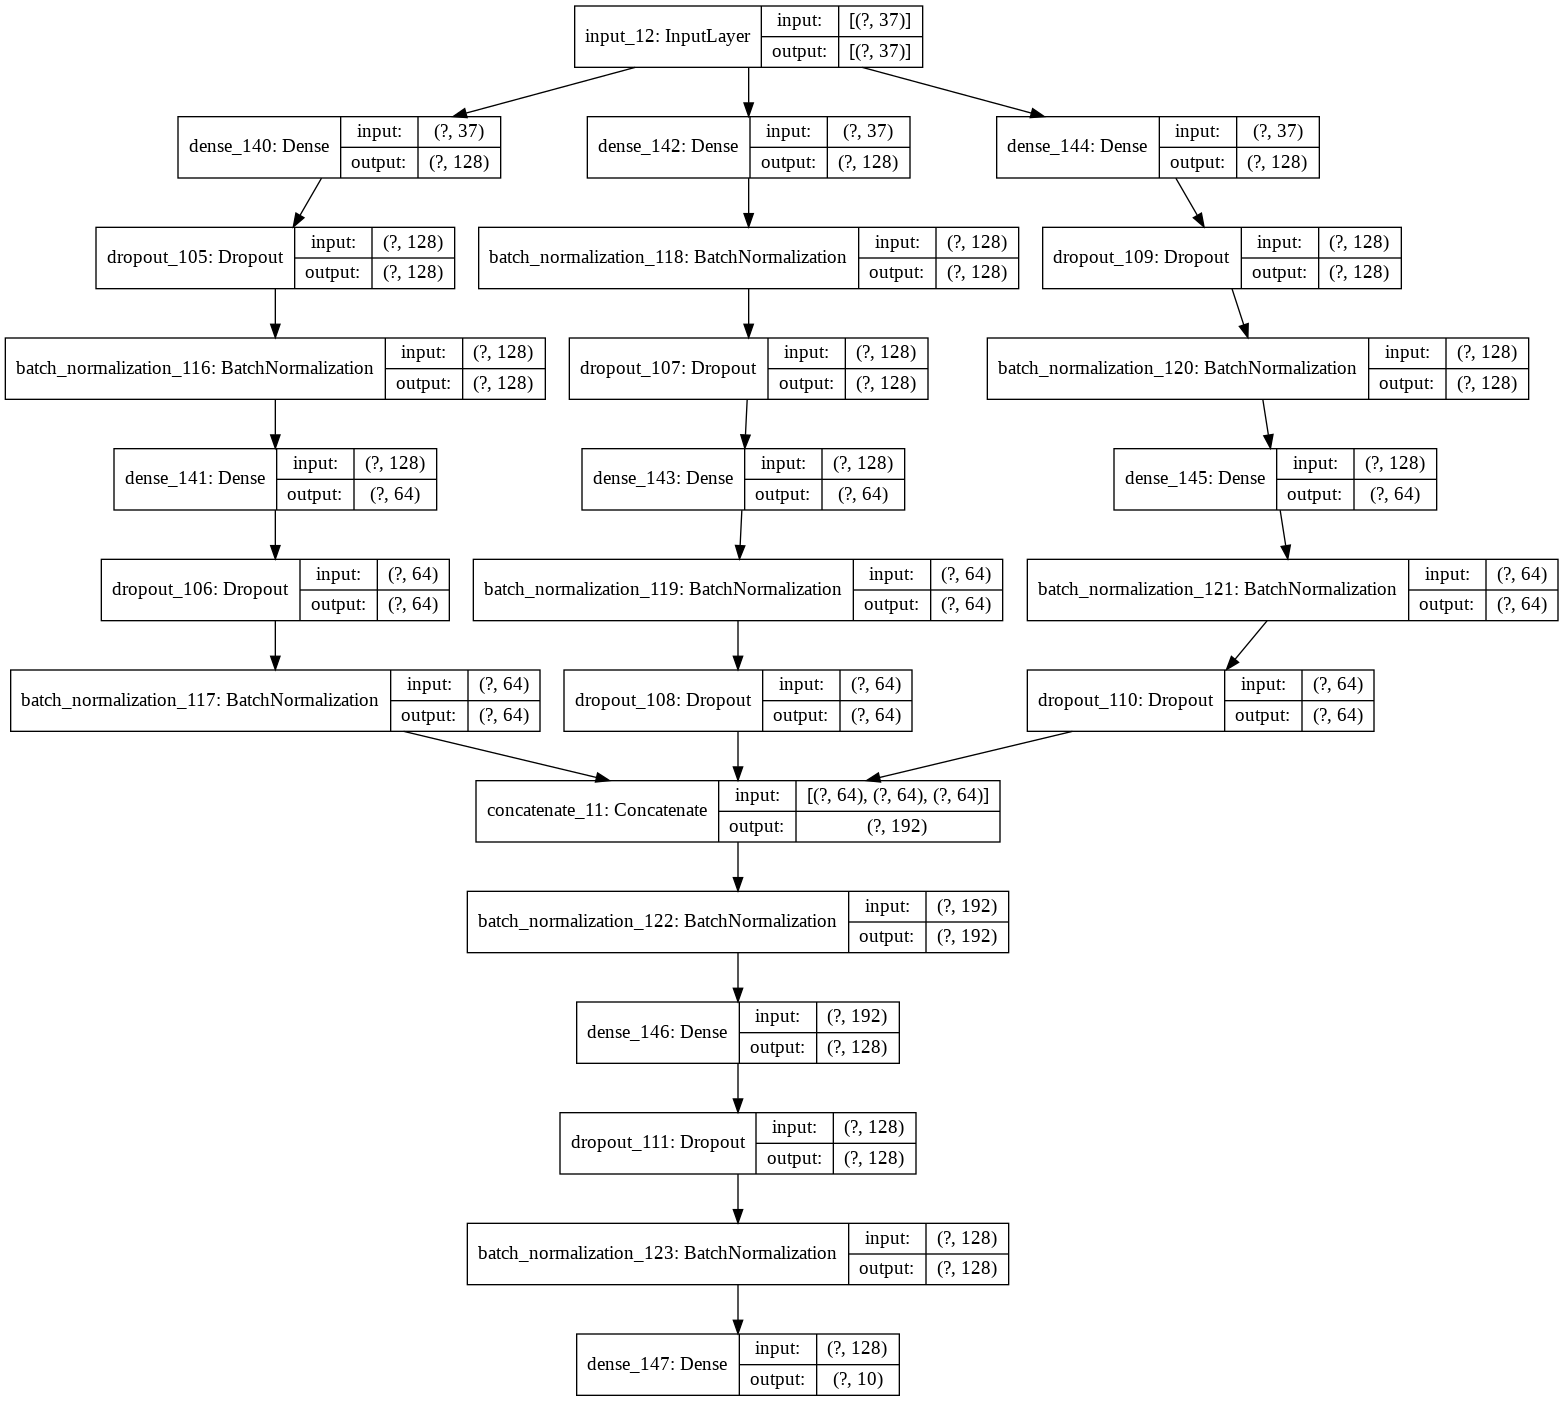

In [ ]:
# Создадим модель нейронной сети и выведем её структуру
indexes = range(0,37)
input1 = Input((len(indexes),))

x1 = Dense(128, activation="elu")(input1)
x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(64, activation="elu")(x1)
x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(128, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(64, activation="elu")(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)

x3 = Dense(128, activation="elu")(input1)
x3 = Dropout(0.5)(x3)
x3 = BatchNormalization()(x3)
x3 = Dense(64, activation="elu")(x3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.5)(x3)

x = concatenate([x1, x2, x3])

x = BatchNormalization()(x)
x = Dense(128, activation='elu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(len(speakers), activation='softmax')(x)

model = Model(input1, x)

plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/55
15/15 [==============================] - 0s 22ms/step - loss: 3.0850 - accuracy: 0.0978 - val_loss: 2.4316 - val_accuracy: 0.1000
Epoch 2/55
15/15 [==============================] - 0s 10ms/step - loss: 2.9533 - accuracy: 0.1044 - val_loss: 2.3671 - val_accuracy: 0.1600
Epoch 3/55
15/15 [==============================] - 0s 9ms/step - loss: 2.9681 - accuracy: 0.1178 - val_loss: 2.3281 - val_accuracy: 0.1800
Epoch 4/55
15/15 [==============================] - 0s 10ms/step - loss: 2.9502 - accuracy: 0.1022 - val_loss: 2.2833 - val_accuracy: 0.1800
Epoch 5/55
15/15 [==============================] - 0s 7ms/step - loss: 3.0052 - accuracy: 0.1000 - val_loss: 2.2446 - val_accuracy: 0.2000
Epoch 6/55
15/15 [==============================] - 0s 7ms/step - loss: 2.9531 - accuracy: 0.0933 - val_loss: 2.2110 - val_accuracy: 0.2000
Epoch 7/55
15/15 [==============================] - 0s 7ms/step - loss: 2.9441 - accuracy: 0.1200 - val_loss: 2.1809 - val_accuracy: 0.2000
Epoch 8/55
15/15 

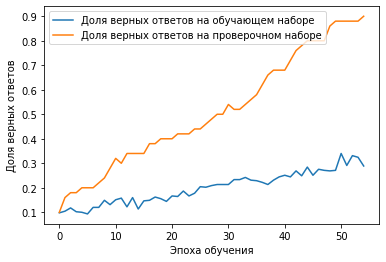

In [ ]:
#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=55,
                    batch_size=30,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Дообучим сеть

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=15,
                    batch_size=30,
                    validation_data=(X_test[:, indexes], y_test))

Epoch 1/15
15/15 [==============================] - 0s 20ms/step - loss: 0.5562 - accuracy: 0.8867 - val_loss: 0.5948 - val_accuracy: 0.9400
Epoch 2/15
15/15 [==============================] - 0s 7ms/step - loss: 0.3929 - accuracy: 0.8844 - val_loss: 0.5964 - val_accuracy: 0.9400
Epoch 3/15
15/15 [==============================] - 0s 9ms/step - loss: 0.6133 - accuracy: 0.8422 - val_loss: 0.5773 - val_accuracy: 0.9400
Epoch 4/15
15/15 [==============================] - 0s 7ms/step - loss: 0.2790 - accuracy: 0.9156 - val_loss: 0.5682 - val_accuracy: 0.9400
Epoch 5/15
15/15 [==============================] - 0s 7ms/step - loss: 0.3664 - accuracy: 0.8956 - val_loss: 0.5711 - val_accuracy: 0.9400
Epoch 6/15
15/15 [==============================] - 0s 7ms/step - loss: 0.2869 - accuracy: 0.8956 - val_loss: 0.5780 - val_accuracy: 0.9600
Epoch 7/15
15/15 [==============================] - 0s 6ms/step - loss: 0.3921 - accuracy: 0.9000 - val_loss: 0.5828 - val_accuracy: 0.9400
Epoch 8/15
15/15 [=

In [ ]:
last_val_accuracy = history.history['val_accuracy'][-1]
print("Точность классификации данных на проверочной выборке:", round(last_val_accuracy*100, 2), "%")

Точность классификации данных на проверочной выборке: 96.0 %


**Протестируем работу сети**

In [ ]:
# Возьмем по одному треку от каждого спикера и протестируем работу сети

for i in speakers:
    songname = './10_speakers_audio_data/' + i + '/' + i + '_00000.wav'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    out = np.array(out).reshape(1,37)
    out = scaler.transform(out)

    #Делаем predict
    y = model.predict(out)

    pred = np.argmax(y)
    real = speakers.index(i)

    if pred == real: print("Спикер {} распознан верно!!!".format(i))
    else: print("Спикер {} - ошибочка вышла, попробуйте еще раз!".format(i))

Спикер Speaker_0006 распознан верно!!!
Спикер Speaker_0005 распознан верно!!!
Спикер Speaker_0003 распознан верно!!!
Спикер Speaker_0007 распознан верно!!!
Спикер Speaker_0001 распознан верно!!!
Спикер Speaker_0002 распознан верно!!!
Спикер Speaker_0008 распознан верно!!!
Спикер Speaker_0009 распознан верно!!!
Спикер Speaker_0010 распознан верно!!!
Спикер Speaker_0004 распознан верно!!!


**Итог:**

Точность классификации данных на проверочной выборке: **96.0 %**
Все спикеры были распознаны правильно. Из чего можно сделать вывод, что даже усредняя данные и без применения балансировки можно добиться отличной работы нейронной сети!